In [83]:
%%capture
!pip install pandas scikit-learn gensim matplotlib
!pip install tokenizers

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from random import seed
import tensorflow as tf
import gensim
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RecallAtPrecision
from tokenizers import CharBPETokenizer, Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

seed(42)

# Task 1

На одной из задач сравните, что лучше: 
1. конкатенировать эмбединги в один большой эмбединг
2. усреднять эмбединги 
3. складывать эмбединги. 

Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

In [40]:
quora = pd.read_csv('quora.csv')
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Preprocess data (use subword)

In [41]:
quora.question_text.to_csv('corpus.txt', index=None)

In [122]:
bpe = CharBPETokenizer()
bpe.train('corpus.txt', vocab_size=50000, min_frequency=30)

In [123]:
bpe.get_vocab_size()

35145

In [124]:
bpe_vocab = bpe.get_vocab()

In [125]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    X.append(bpe.encode(text).ids)

In [126]:
MAX_LEN = max(len(x) for x in X)
MAX_LEN

634

In [127]:
MAX_LEN = 200

In [128]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 200)

In [129]:
y = quora.target.values
y.shape

(1306122,)

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Train the model

1. конкатенировать эмбединги в один большой эмбединг

In [131]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(bpe_vocab), output_dim=100)(inputs, )
flat = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [132]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 200, 100)          3514500   
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1280064   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 4,794,629
Trainable params: 4,794,629
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=20)

Epoch 1/20
606/606 [==============================] - 64s 104ms/step - loss: 0.2330 - accuracy: 0.9379 - val_loss: 0.1413 - val_accuracy: 0.9459
Epoch 2/20
606/606 [==============================] - 63s 103ms/step - loss: 0.1319 - accuracy: 0.9486 - val_loss: 0.1234 - val_accuracy: 0.9508
Epoch 3/20
606/606 [==============================] - 62s 103ms/step - loss: 0.1162 - accuracy: 0.9534 - val_loss: 0.1174 - val_accuracy: 0.9534
Epoch 4/20
606/606 [==============================] - 63s 103ms/step - loss: 0.1083 - accuracy: 0.9561 - val_loss: 0.1150 - val_accuracy: 0.9538
Epoch 5/20
606/606 [==============================] - 63s 104ms/step - loss: 0.1025 - accuracy: 0.9584 - val_loss: 0.1142 - val_accuracy: 0.9545
Epoch 6/20
606/606 [==============================] - 63s 104ms/step - loss: 0.0994 - accuracy: 0.9591 - val_loss: 0.1144 - val_accuracy: 0.9541
Epoch 7/20
606/606 [==============================] - 63s 104ms/step - loss: 0.0956 - accuracy: 0.9608 - val_loss: 0.1150 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


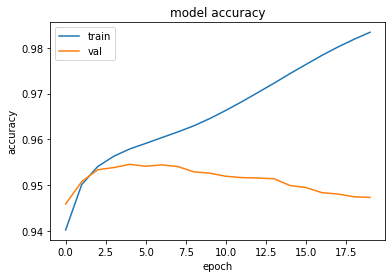

In [134]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [135]:
preds = model.predict(X_valid).reshape(-1)
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     61272
           1       0.58      0.51      0.55      4035

    accuracy                           0.95     65307
   macro avg       0.78      0.74      0.76     65307
weighted avg       0.94      0.95      0.95     65307



2. усреднять эмбединги

In [136]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(bpe_vocab), output_dim=100)(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [137]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 100)          3514500   
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 3,521,029
Trainable params: 3,521,029
Non-trainable params: 0
_________________________________________________________________


In [138]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=20)

Epoch 1/20
606/606 [==============================] - 61s 100ms/step - loss: 0.5582 - accuracy: 0.8742 - val_loss: 0.2357 - val_accuracy: 0.9382
Epoch 2/20
606/606 [==============================] - 61s 100ms/step - loss: 0.2300 - accuracy: 0.9380 - val_loss: 0.2242 - val_accuracy: 0.9382
Epoch 3/20
606/606 [==============================] - 61s 100ms/step - loss: 0.2230 - accuracy: 0.9383 - val_loss: 0.2203 - val_accuracy: 0.9382
Epoch 4/20
606/606 [==============================] - 61s 100ms/step - loss: 0.2192 - accuracy: 0.9380 - val_loss: 0.2134 - val_accuracy: 0.9382
Epoch 5/20
606/606 [==============================] - 61s 101ms/step - loss: 0.2105 - accuracy: 0.9380 - val_loss: 0.1984 - val_accuracy: 0.9384
Epoch 6/20
606/606 [==============================] - 61s 101ms/step - loss: 0.1920 - accuracy: 0.9387 - val_loss: 0.1773 - val_accuracy: 0.9406
Epoch 7/20
606/606 [==============================] - 61s 101ms/step - loss: 0.1721 - accuracy: 0.9407 - val_loss: 0.1607 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


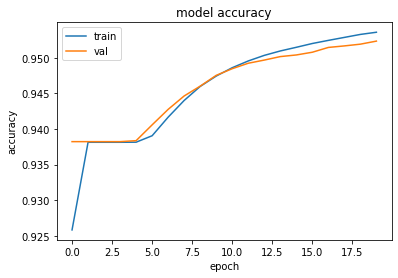

In [139]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [140]:
preds = model.predict(X_valid).reshape(-1)
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     61272
           1       0.68      0.43      0.53      4035

    accuracy                           0.95     65307
   macro avg       0.82      0.71      0.75     65307
weighted avg       0.95      0.95      0.95     65307



3. складывать эмбединги.

In [141]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(bpe_vocab), output_dim=100)(inputs, )
sums = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(sums)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [142]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 200, 100)          3514500   
_________________________________________________________________
lambda_3 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 3,521,029
Trainable params: 3,521,029
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=20)

Epoch 1/20
606/606 [==============================] - 61s 100ms/step - loss: 0.1900 - accuracy: 0.9402 - val_loss: 0.1386 - val_accuracy: 0.9461
Epoch 2/20
606/606 [==============================] - 60s 99ms/step - loss: 0.1295 - accuracy: 0.9499 - val_loss: 0.1239 - val_accuracy: 0.9511
Epoch 3/20
606/606 [==============================] - 60s 99ms/step - loss: 0.1161 - accuracy: 0.9541 - val_loss: 0.1181 - val_accuracy: 0.9527
Epoch 4/20
606/606 [==============================] - 60s 99ms/step - loss: 0.1103 - accuracy: 0.9559 - val_loss: 0.1160 - val_accuracy: 0.9548
Epoch 5/20
606/606 [==============================] - 60s 99ms/step - loss: 0.1060 - accuracy: 0.9572 - val_loss: 0.1154 - val_accuracy: 0.9546
Epoch 6/20
606/606 [==============================] - 61s 100ms/step - loss: 0.1031 - accuracy: 0.9582 - val_loss: 0.1138 - val_accuracy: 0.9555
Epoch 7/20
606/606 [==============================] - 60s 99ms/step - loss: 0.1005 - accuracy: 0.9592 - val_loss: 0.1160 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


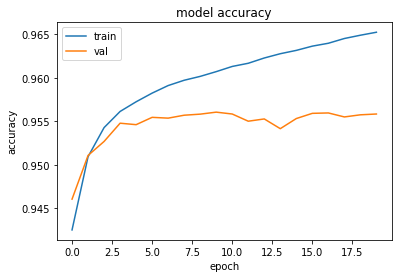

In [144]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
preds = model.predict(X_valid).reshape(-1)
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61272
           1       0.68      0.54      0.60      4035

    accuracy                           0.96     65307
   macro avg       0.83      0.76      0.79     65307
weighted avg       0.95      0.96      0.95     65307



`Flattening` provides highest results (on train), though the difference between train and val increases over time (val is even decreasing). `Averaging` is more balanced in the same situation, though the results are a bit (insignificant on val) lower.
`Summing` seems to be the best one as it is more or less balanced and the highest on val

# Task 2

В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче)

**utils**

In [146]:
quora = pd.read_csv('quora.csv')
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [147]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

preprocess

In [148]:
# словарь
vocab = Counter()
texts = quora.question_text.apply(preprocess).tolist()

for text in texts:
    vocab.update(text)

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [149]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [150]:
# переводим тексты в последовательности индексов
X = []

for tokens in texts:
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [151]:
MAX_LEN = max(len(x) for x in X)

In [152]:
MAX_LEN

134

In [153]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
y = quora.target.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

**use basic tokenization to apply third-party embeddings**

In [154]:
%%time
""" a model with default parameters
    min_count=5, window=5, iter=5
"""
# if error, add a second parameter == vector_size=MAX_LEN
ft = gensim.models.FastText(texts)

CPU times: user 9min 6s, sys: 1.96 s, total: 9min 8s
Wall time: 4min 51s


In [155]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights[i] = ft.wv['опрагпллирао']

In [156]:
%%time
""" a model with changed parameters
    min_count=3, window=7, iter=7
"""
ft2 = gensim.models.FastText(texts, min_count=3, window=7, iter=7)

CPU times: user 14min 40s, sys: 3.04 s, total: 14min 43s
Wall time: 7min 45s


In [157]:
weights2 = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights2[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights2[i] = ft.wv['опрагпллирао']

train

In [162]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
# apply the first set weights
embeddings1 = tf.keras.layers.Embedding(input_dim=len(word2id),
                                       output_dim=100,
                                       trainable=False,
                                       weights=[weights])(inputs, )
# apply the second set of weights
embeddings2 = tf.keras.layers.Embedding(input_dim=len(word2id), 
                                       output_dim=100, 
                                       trainable=False,
                                       weights=[weights2])(inputs, )

embeddings = tf.keras.layers.Average()([embeddings1, embeddings2])
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [163]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2054,
          epochs=20)

Epoch 1/20
605/605 [==============================] - 29s 47ms/step - loss: 0.5511 - accuracy: 0.8431 - val_loss: 0.3091 - val_accuracy: 0.9374
Epoch 2/20
605/605 [==============================] - 29s 47ms/step - loss: 0.2882 - accuracy: 0.9378 - val_loss: 0.2395 - val_accuracy: 0.9374
Epoch 3/20
605/605 [==============================] - 29s 47ms/step - loss: 0.2257 - accuracy: 0.9383 - val_loss: 0.1942 - val_accuracy: 0.9387
Epoch 4/20
605/605 [==============================] - 29s 47ms/step - loss: 0.1876 - accuracy: 0.9401 - val_loss: 0.1727 - val_accuracy: 0.9408
Epoch 5/20
605/605 [==============================] - 29s 47ms/step - loss: 0.1699 - accuracy: 0.9418 - val_loss: 0.1623 - val_accuracy: 0.9422
Epoch 6/20
605/605 [==============================] - 29s 47ms/step - loss: 0.1609 - accuracy: 0.9428 - val_loss: 0.1564 - val_accuracy: 0.9426
Epoch 7/20
605/605 [==============================] - 28s 47ms/step - loss: 0.1552 - accuracy: 0.9440 - val_loss: 0.1526 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


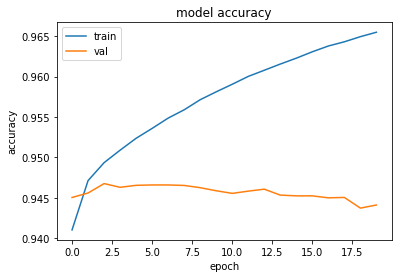

In [160]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [161]:
preds = model.predict(X_valid).reshape(-1)
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     61218
           1       0.58      0.39      0.47      4089

    accuracy                           0.94     65307
   macro avg       0.77      0.69      0.72     65307
weighted avg       0.94      0.94      0.94     65307

